In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.font_manager as fm


df = pd.read_csv("출자구조.CSV", encoding="cp949")

In [27]:
df

,피소유 기관,소유 기관,지분,비고
0,인천국제공항공사,국토교통부,100.00,NaN
1,한국가스공사,정부,26.15,NaN
2,한국가스공사,한국전력공사,20.47,NaN
3,한국가스공사,지방자치단체,7.39,NaN
4,한국가스공사,우리사주,1.07,NaN
...,...,...,...,...
106,기업은행,수출입은행,1.84,NaN
107,기업은행,기타,31.46,NaN
108,수출입은행,정부,76.38,NaN
109,수출입은행,산업은행,16.72,NaN


In [28]:
#한글 폰트 오류 방지
font_path = 'C:\\Windows\\Fonts\\malgun.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False 

In [29]:
UserInput = ['정부']

In [30]:
#함수 정의
def org_owners(df, target_orgs):
    results = {}
    for org in target_orgs:
        owners = df[df['피소유 기관'] == org]['소유 기관'].tolist()
        if owners:
            results[org] = owners
            sub_results = org_owners(df, owners)
            for key, value in sub_results.items():
                results[key] = value
    return results

def org_owning(df, target_orgs):
    results = {}
    for org in target_orgs:
        owned = df[df['소유 기관'] == org]['피소유 기관'].tolist()
        if owned:
            results[org] = owned
            sub_results = org_owning(df, owned)
            for key, value in sub_results.items():
                results[key] = value
    return results


In [31]:
orgOwners = org_owners(df, UserInput)
orgOwning = org_owning(df, UserInput)

print(f"각 기관의 지분을 가진 기관:\n{orgOwners}")
print(f"\n각 기관이 지분을 가진 기관:\n{orgOwning}")


각 기관의 지분을 가진 기관:
{}

각 기관이 지분을 가진 기관:
{'정부': ['한국가스공사', '한국석유공사', '한국전력공사', '대한석탄공사', '한국광해광업공단', '한국수자원공사', '한국철도공사', '한국토지주택공사', '한국주택금융공사', '한국해양진흥공사', '기업은행', '수출입은행'], '한국전력공사': ['한국가스공사', '한국남동발전', '한국남부발전', '한국동서발전', '한국서부발전', '한국수력원자력', '한국중부발전', '한국지역난방공사'], '한국수자원공사': ['한국해외인프라도시개발지원공사'], '한국철도공사': ['한국해외인프라도시개발지원공사'], '한국토지주택공사': ['한국해외인프라도시개발지원공사'], '한국해양진흥공사': ['부산항만공사', '여수광양항만공사', '울산항만공사', '인천항만공사'], '수출입은행': ['여수광양항만공사', '기업은행']}


In [ ]:
DI = nx.DiGraph()

# 2. adding nodes
all_nodes = set(orgOwners.keys()) | set(orgOwning.keys())
for owners in orgOwners.values():
    all_nodes.update(owners)
for owned in orgOwning.values():
    all_nodes.update(owned)
DI.add_nodes_from(all_nodes)
DI.add_nodes_from(UserInput)

{'한국철도공사', '한국서부발전', '한국전력공사', '부산항만공사', '한국지역난방공사', '한국중부발전', '한국해외인프라도시개발지원공사', '여수광양항만공사', '한국남동발전', '한국토지주택공사', '한국남부발전', '정부', '인천항만공사', '한국가스공사', '한국수력원자력', '한국석유공사', '한국수자원공사', '한국광해광업공단', '기업은행', '울산항만공사', '한국동서발전', '대한석탄공사', '한국해양진흥공사', '한국주택금융공사', '수출입은행'}


In [ ]:
# 3. edges classification
edges_userOwner = []
edges_userOwns = []
orgs_notuser = []

for owner, owned_list in orgOwning.items():
    for owned in owned_list:
        weight = df[(df['피소유 기관'] == owned) & (df['소유 기관'] == owner)]['지분'].tolist()
        
        DI.add_edge(owner, owned, weight = weight[0])

        if owner in UserInput:
            edges_userOwner.append((owner, owned))
        else:
            orgs_notuser.append((owner, owned))



for owned, owner_list in orgOwners.items():
    for owner in owner_list:
        weight = df[(df['피소유 기관'] == owned) & (df['소유 기관'] == owner)]['지분'].tolist()
        
        DI.add_edge(owner, owned, weight = weight[0])

        if owned in UserInput:
            edges_userOwns.append((owner, owned))
        else:
            orgs_notuser.append((owner, owned))


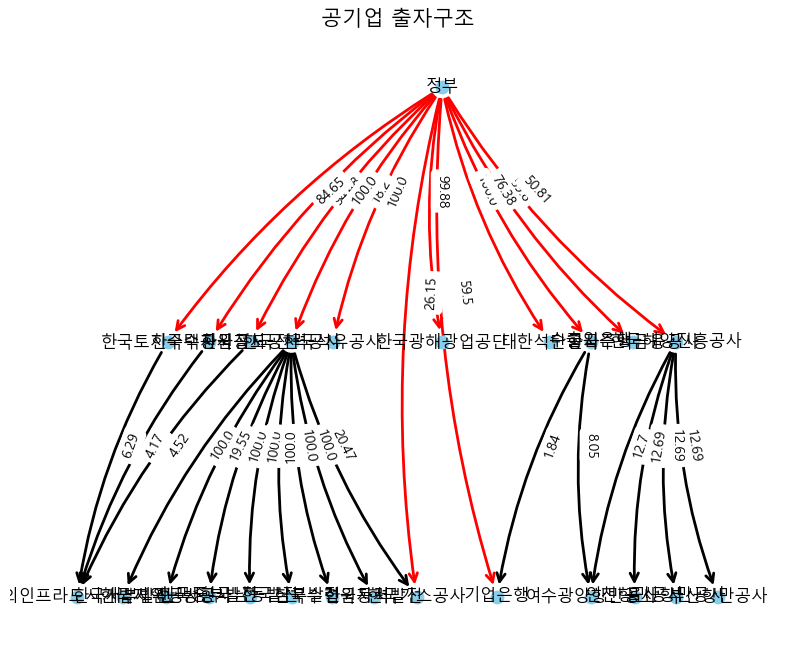

In [34]:
# 4. visualization
plt.figure(figsize=(10, 8))

#node position
DI.graph['graph'] = {'ranksep': '50', 'nodesep': '10'}

#layout
pos = nx.nx_pydot.graphviz_layout(DI, prog='dot')

#drawing
nx.draw_networkx_nodes(DI, pos, node_color='skyblue', node_size=80)

connect_style = 'arc3,rad=0.1'

# UserInput Owning
nx.draw_networkx_edges(DI, pos, edgelist=edges_userOwns, connectionstyle=connect_style, edge_color='green', arrowstyle='->', arrowsize=15, width=2)
# UserInput's Owners
nx.draw_networkx_edges(DI, pos, edgelist=edges_userOwner, connectionstyle=connect_style, edge_color='red', arrowstyle='->', arrowsize=15, width=2)
# other orgs
nx.draw_networkx_edges(DI, pos, edgelist=orgs_notuser, connectionstyle=connect_style, edge_color='black', arrowstyle='->', arrowsize=15, width=2)

# labels
nx.draw_networkx_labels(DI, pos, font_size=12, font_family='malgun gothic')

labels = nx.get_edge_attributes(DI, 'weight')

nx.draw_networkx_edge_labels(DI, pos, edge_labels=labels, label_pos=0.4, font_family = 'malgun gothic', font_size=10)


plt.title("공기업 출자구조", fontsize=15)
plt.axis('off')
plt.show()